# LSTM Multivariate

https://colab.research.google.com/drive/1b3CUJuDOmPmNdZFH3LQDmt5F0K3FZhqD?usp=sharing#scrollTo=vdaqGHG4YZkN

In [169]:
import tensorflow as tf
import pandas as pd
import numpy as np
import pandas as pd

In [170]:
df = pd.read_csv('consumption_and_temperatures.csv')

df['timestamp'] = pd.to_datetime(df['timestamp'])

df = df[['timestamp', 'NO4_temperature', 'NO4_consumption']]
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['hour'] = df['timestamp'].dt.hour

df.set_index('timestamp', inplace=True)
df.columns

Index(['NO4_temperature', 'NO4_consumption', 'month', 'day', 'hour'], dtype='object')

In [171]:
df.head()

,NO4_temperature,NO4_consumption,month,day,hour
timestamp,,,,,
2017-05-01 00:00:00+00:00,0.2,2061.209,5,1,0
2017-05-01 01:00:00+00:00,0.1,2045.436,5,1,1
2017-05-01 02:00:00+00:00,0.1,2020.007,5,1,2
2017-05-01 03:00:00+00:00,0.1,2021.920,5,1,3
2017-05-01 04:00:00+00:00,0.1,2045.913,5,1,4


In [172]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
df[['NO4_temperature', 'NO4_consumption', 'month', 'day', 'hour']] = scaler.fit_transform(df[['NO4_temperature', 'NO4_consumption', 'month', 'day', 'hour']])

In [173]:
train_data = df[:int(0.999*len(df))]
test_data  = df[int(0.999*len(df)):]


In [174]:
X_train = train_data[['NO4_temperature', 'month', 'day', 'hour', 'NO4_consumption']]
y_train = train_data['NO4_consumption']

X_test = test_data[['NO4_temperature', 'month', 'day', 'hour', 'NO4_consumption']]
y_test = test_data['NO4_consumption']

n_features = 5

train_data_series = X_train.values.reshape(len(X_train), n_features)
train_target_series = y_train.values.reshape((len(y_train), 1))
test_data_series = X_test.values.reshape(len(X_test), n_features)
test_target_series  = y_test.values.reshape((len(y_test), 1))

In [175]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

look_back = 24

train_generator = TimeseriesGenerator(train_data_series, train_target_series,
                                      length        = look_back,
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = 10)

test_generator = TimeseriesGenerator(test_data_series, test_target_series,
                                      length        = look_back,
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = 10)

In [176]:
train_generator[0]

(array([[[0.36105033, 0.36363636, 0.        , 0.        , 0.37726562],
         [0.35886214, 0.36363636, 0.        , 0.04347826, 0.36872655],
         [0.35886214, 0.36363636, 0.        , 0.08695652, 0.35495997],
         ...,
         [0.38730853, 0.36363636, 0.        , 0.91304348, 0.45067633],
         [0.38074398, 0.36363636, 0.        , 0.95652174, 0.42521989],
         [0.38074398, 0.36363636, 0.        , 1.        , 0.40404517]],
 
        [[0.35886214, 0.36363636, 0.        , 0.04347826, 0.36872655],
         [0.35886214, 0.36363636, 0.        , 0.08695652, 0.35495997],
         [0.35886214, 0.36363636, 0.        , 0.13043478, 0.35599562],
         ...,
         [0.38074398, 0.36363636, 0.        , 0.95652174, 0.42521989],
         [0.38074398, 0.36363636, 0.        , 1.        , 0.40404517],
         [0.38512035, 0.36363636, 0.03333333, 0.        , 0.39053251]],
 
        [[0.35886214, 0.36363636, 0.        , 0.08695652, 0.35495997],
         [0.35886214, 0.36363636, 0.       

In [177]:
%%time

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

n_neurons  = 10
model = Sequential()
model.add(LSTM(n_neurons, input_shape=(look_back, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse');

model.fit(train_generator,epochs=2, verbose=1);

Epoch 1/2


c:\Users\vadim\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  20/5839 ━━━━━━━━━━━━━━━━━━━━ 48s 8ms/step - loss: 0.0727

c:\Users\vadim\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5839/5839 ━━━━━━━━━━━━━━━━━━━━ 45s 7ms/step - loss: 0.0076
Epoch 2/2
5839/5839 ━━━━━━━━━━━━━━━━━━━━ 43s 7ms/step - loss: 5.5288e-04
CPU times: total: 40.2 s
Wall time: 1min 28s


In [178]:
test_predictions  = model.predict(test_generator)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


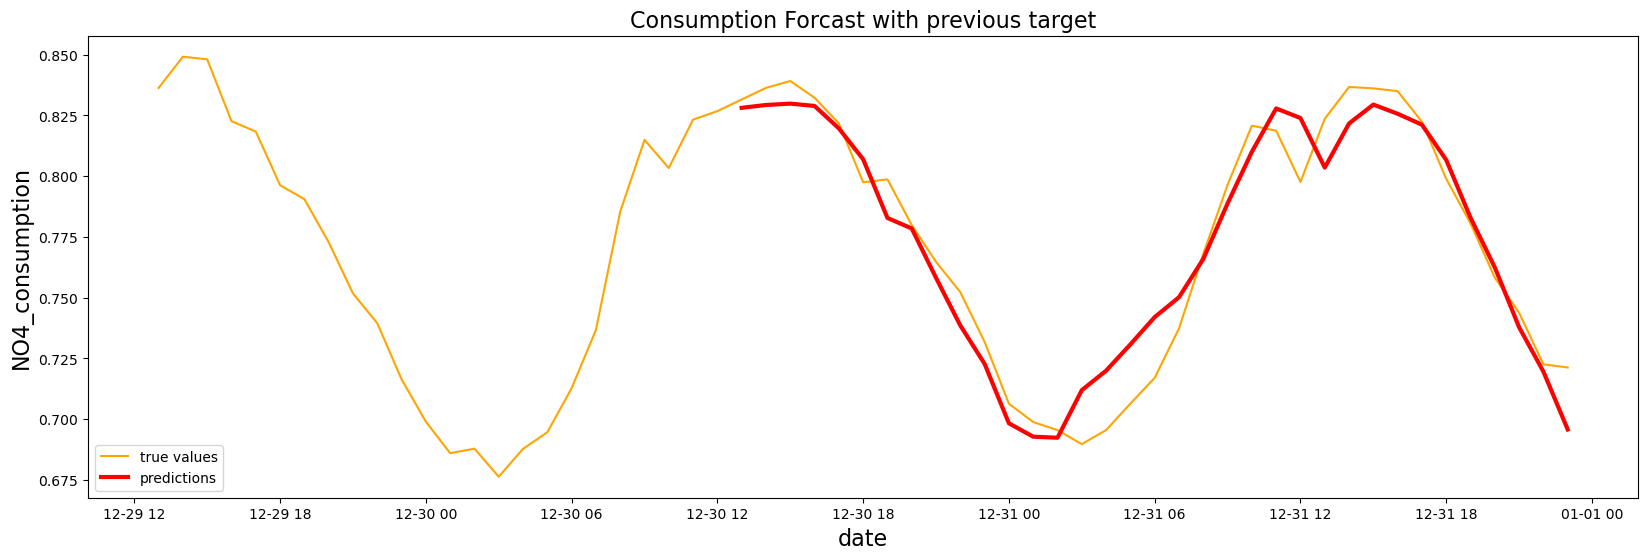

In [185]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,6))
plt.plot(test_data.index, test_data['NO4_consumption'], c='orange',label='true values')
plt.plot(X_test.index[24:],test_predictions, lw=3, c='r',linestyle = '-', label='predictions')
plt.legend(loc="lower left")
plt.xlabel("date", fontsize=16)
plt.ylabel("NO4_consumption", fontsize=16)
plt.title("Consumption Forcast with previous target", fontsize=16);

In [181]:
extrapolation = list()
seed_batch = X_test[:look_back].values.reshape((1,look_back, n_features))
current_batch = seed_batch

for i in range(len(test_data)-look_back):
    predicted_value = model.predict(current_batch)[0]
    extrapolation.append(predicted_value)
    next_step = np.append(X_test.iloc[i+look_back,:4].values,[predicted_value])
    current_batch = np.append(current_batch[:,1:,:],[[next_step]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━

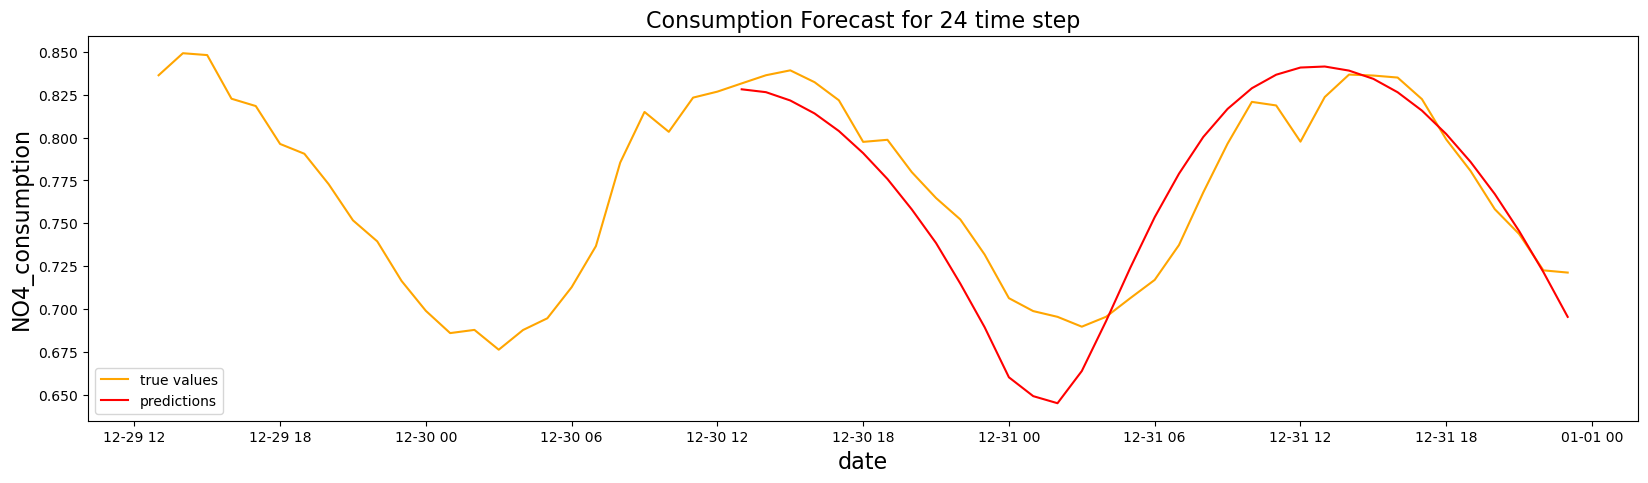

In [184]:
plt.figure(figsize=(20,5))
plt.plot(test_data.index, test_data['NO4_consumption'], c='orange',label='true values')
plt.plot(X_test.index[24:],extrapolation, c='r',linestyle = '-', label='predictions')
plt.legend(loc="lower left")
plt.xlabel("date", fontsize=16)
plt.ylabel("NO4_consumption", fontsize=16)
plt.title("Consumption Forecast for 24 time step", fontsize=16);